In [43]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.filters import gaussian

import matplotlib.patches as mpatches
from skimage.measure import label, regionprops
from skimage.util import invert
from scipy.spatial.distance import euclidean

import numpy as np
from skimage.draw import polygon_perimeter
from commonfunctions import *

import cv2
import numpy as np
from commonfunctions import *

from skimage.measure import compare_ssim

In [44]:
image=imread('times-new-roman.jpg')

gray_img = rgb2gray(image)

#blur the image to remove any noise
blurred_gray_img = gaussian(gray_img)
plt.figure(figsize=(20,20))
#plt.axis("off")
#plt.imshow(blurred_gray_img, cmap="gray")

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

(0.0, 1.0, 0.0, 1.0)

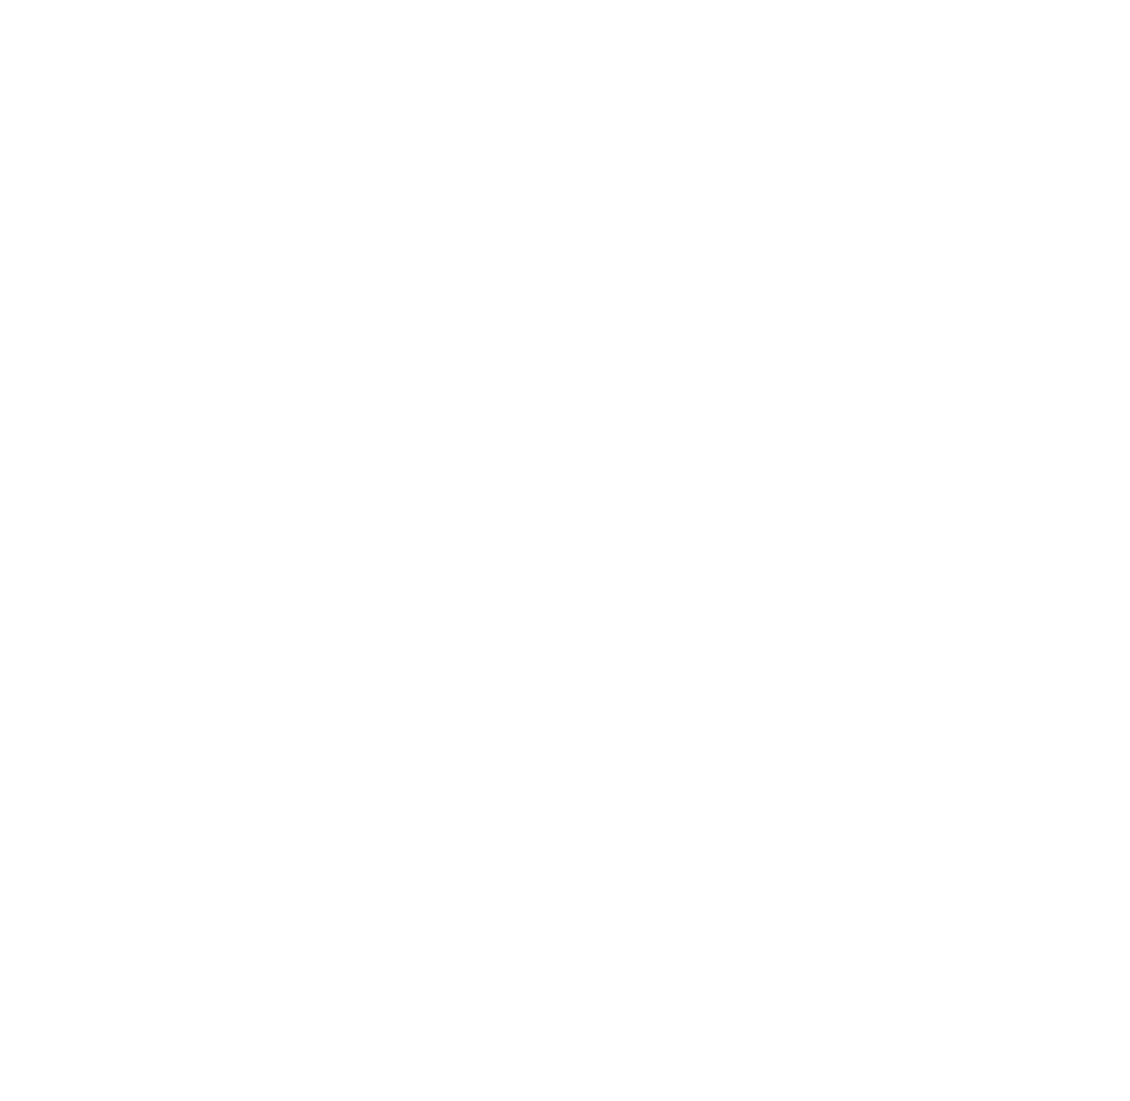

In [45]:
thresh = threshold_otsu(gray_img)
binary = invert(gray_img > thresh)

plt.figure(figsize=(20,20))
plt.axis("off")
#plt.imshow(binary, cmap="gray")

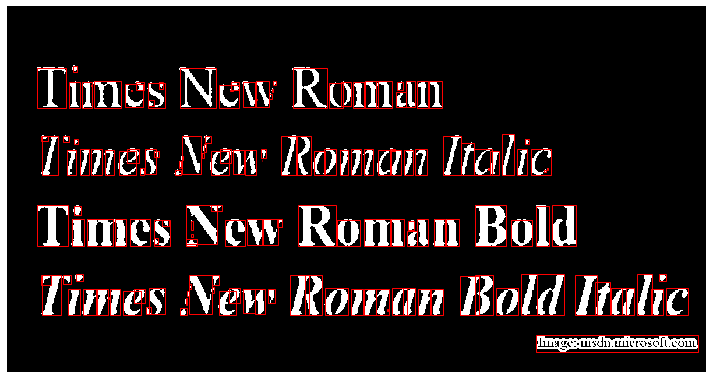

In [46]:

label_image = label(binary, connectivity=2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")
ax.imshow(binary, cmap="gray")




for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)
#     print(rect)
#showHist( label_image[minc:minc + maxc, minr:minr + maxr])
plt.tight_layout()
#plt.show()


In [87]:

alphabetics_dict = {}
Alpha_numeric_list=['A','B','C','D','E','F','G','H','I','G','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
                    '0','1','2','3','4','5','6','7','8','9',
                    'a','b','c','d','e','f','g','h','i','g','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']



# import image
def read_image(image):
    image = cv2.imread(image)
    return image

#read letters images and save their histograms
def readletters():
    for i in range(len(Alpha_numeric_list)):
        alphabetics_dict.update( { Alpha_numeric_list[i] : histogram(
            rgbtogray(read_image( "alphanumeric/" + Alpha_numeric_list[i] + ".png"))) } )

#read letters images and save their histograms
def read_input_image():
    hist_list=[]
    for i in range(len(Alpha_numeric_list)):
        alphabetics_dict.update( { Alpha_numeric_list[i] : histogram(
            rgbtogray(read_image( "alphanumeric/" + Alpha_numeric_list[i] + ".png"))) } )
        
# grayscale
def rgbtogray(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray
# cv2.imshow('threshold', thresh)

# dilation
def dilation(thresh):
    kernel = np.ones((10, 1), np.uint8)
    img_dilation = cv2.dilate(thresh, kernel, iterations=1)
    return img_dilation
# cv2.imshow('dilated', img_dilation)
    
# cv2.imshow('gray', gray)

# binary
def convert_to_binary(gray):
    ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    return ret,thresh

# find contours and sort them
def find_contours(img_dilation):
    ctrs, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
    return sorted_ctrs

def chi2_distance(histA, histB, eps = 1e-10):
    
    # compute the chi-squared distance
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)for (a, b) in zip(histA, histB)])
    return d

#save letters bounded in rectangles
def get_letters(sorted_ctrs,image): 
    for i, ctr in enumerate(sorted_ctrs):
        # Get bounding box
        x, y, w, h = cv2.boundingRect(ctr)

        # Getting ROI
        roi = image[y:y + h, x:x + w]

        # show ROI
        #cv2.imshow('segment no:'+str(i),roi)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        if w > 15 and h > 15:
            cv2.imwrite('alphanumeric\\{}.png'.format(i), roi)
#cv2.imshow('marked areas', image)
#cv2.waitKey(0)

def get_minimum_diff(alphabetics_dict,grayroi):
    localresult=[]
    for key in alphabetics_dict:
        value = alphabetics_dict[key]
        if np.array([histogram(grayroi)]).shape!=np.array([value]).shape:
            continue
        d = cv2.compareHist(np.float32(histogram(grayroi)),np.float32(value), cv2.HISTCMP_BHATTACHARYYA)
        localresult.append(d)
    mini=min(localresult)
    return mini

def match_letters(sorted_ctrs,inputimage):
    globalresult=[]
    grayroi=[]
    for i, ctr in enumerate(sorted_ctrs):
        x, y, w, h = cv2.boundingRect(ctr)
        # Getting ROI
        roi = inputimage[y:y + h, x:x + w]
        grayroi.append(cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)) 
        mini=get_minimum_diff(alphabetics_dict,grayroi[i])
        for key_min in alphabetics_dict:
            value_min= alphabetics_dict[key_min]
            if np.array([histogram(grayroi[i])]).shape!=np.array([value_min]).shape:
                continue
            d = cv2.compareHist(np.float32(histogram(grayroi[i])),np.float32(value_min), cv2.HISTCMP_BHATTACHARYYA)
            if d==mini:
                globalresult.append(key_min)
    return globalresult   

def compute_signatures(hist1, hist2, h_bins = 256, s_bins = 256):
    #demos how to convert 2 histograms into 2 signature
    num_rows = h_bins * s_bins
    sig1 = cv2.createMat(num_rows, 3, cv2.CV_32FC1)
    sig2 = cv2.createMat(num_rows, 3, cv2.CV_32FC1)
    #fill signatures
    #TODO: for production optimize this, use Numpy
    for h in range(0, h_bins):
        for s in range(0, s_bins):
            bin_val = cv2.QueryHistValue_2D(hist1, h, s)
            cv2.Set2D(sig1, h*s_bins + s, 0, bin_val) #bin value
            cv2.Set2D(sig1, h*s_bins + s, 1, h)  #coord1
            cv2.Set2D(sig1, h*s_bins + s, 2, s) #coord2
            #signature.2
            bin_val2 = cv2.QueryHistValue_2D(hist2, h, s)
            cv2.Set2D(sig2, h*s_bins + s, 0, bin_val2) #bin value
            cv2.Set2D(sig2, h*s_bins + s, 1, h)  #coord1
            cv2.Set2D(sig2, h*s_bins + s, 2, s) #coord2

    return (sig1, sig2)

def compute_emd(hist1, hist2):
    #hist1  = compute_histogram(src1, h_bins, s_bins, scale)
    #hist2  = compute_histogram(src2, h_bins, s_bins, scale)
    sig1, sig2 = compute_signatures(hist1, hist2)
    emd = cv2.CalcEMD2(sig1, sig2, cv2.CV_DIST_L2)
    return emd

#match letters with input image by histogram
def match_letters_yousry(sorted_ctrs,inputimage):
    globalresult=[]
    for i, ctr in enumerate(sorted_ctrs):
        x, y, w, h = cv2.boundingRect(sorted_ctrs[i])
        #print(sorted_ctrs[i])
        # Getting ROI
        roi = inputimage[y:y + h, x:x + w]
        grayroi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
#         histrgb=histogram(grayroi)
#         print(len(histrgb))
        localresult=100000
        char=[]
        for input_letter in alphabetics_dict:
            input_hist = alphabetics_dict[input_letter]
            if np.array([histogram(grayroi)]).shape!=np.array([input_hist]).shape:
                continue
            #h1=cv2.normalize(histogram(grayroi), histogram(grayroi), alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
            #h2=cv2.normalize(input_hist, input_hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
            #d = cv2.compareHist(np.float32(histogram(grayroi)),np.float32(input_hist), cv2.HISTCMP_CHISQR)
            d = compute_emd(histogram(grayroi),input_hist)
            print(localresult)
            print("d is: " + d)
#             if (input_letter == "a"):
#                 print("a")
#                 print(d)
            if d < localresult:
                print("d is:" + str(d))
                print("local res before: " + str(localresult))
                localresult = d
                print("local res after: " + str(localresult))
                print("char to be appended: " + (input_letter))
                char.append(input_letter)
        #print(char[-1])
        if len(char) != 0:
            globalresult.append( char[-1] ) 
        print(globalresult)
        print("*************")
        char=[]
        #print(char)
    
    return globalresult

def fill_dict_images():
    for i in range(len(Alpha_numeric_list)):
        alphabetics_dict.update( { Alpha_numeric_list[i] :
                                  rgbtogray(read_image( "alphanumeric/" + Alpha_numeric_list[i] + ".png")) } )
    return

def DifferenceBetweenImages(grayA,grayB):
    (score, diff) = compare_ssim(grayA, grayB, full=True)
    diff = (diff * 255).astype("uint8")
    return scoree,diff

#match letters with input image by histogram
def matchfromdifference(sorted_ctrs,inputimage):
    globalresult=[]
    for i, ctr in enumerate(sorted_ctrs):
        x, y, w, h = cv2.boundingRect(sorted_ctrs[i])
        #print(sorted_ctrs[i])
        # Getting ROI
        roi = inputimage[y:y + h, x:x + w]
        grayroi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        localscore=-1000
        char=[]
        print("grayroi shape: "+ str( grayroi.shape[0] )+ " "+str( grayroi.shape[1])  )

        for input_letter in alphabetics_dict:
            LettersGrayImage = alphabetics_dict[input_letter]
            #print("geh hena")
            print("letter shape: "+ str(LettersGrayImage.shape[0])+ " "+ str(LettersGrayImage.shape[1])  )
            if np.array(grayroi).shape!=np.array(LettersGrayImage).shape:
                continue
            score,diff = DifferenceBetweenImages(grayroi,LettersGrayImage)
            print("score "+score+" diff "+diff)
            if score > localscore:
                localscore=score
                char.append(input_letter)
        print("**************")       
        #print(char[-1])
        if len(char) != 0:
            globalresult.append( char[-1] ) 
        char=[]
        #print(char)
    
    return globalresult 



In [88]:
#Correlation - CV_COMP_CORREL, high score represent a better match than a low score.
#Chi-square, low score represents a better match than a high score.A perfect match is ) and a total mismatch is unbounded.
#Intersection ,high score indicates good matches. If both histograms are normalized to 1, then a perect match is 1 and total mismatch is 0.
#Bhatttacharyya distance , low scores indicate good matches and high scores indicate bad matches.

In [89]:
def GetSeparatedLetters():
    image=read_image('alphabets.jpg')
    gray=rgbtogray(image)
    ret,thres=convert_to_binary(gray)
    img_dilation=dilation(thres)
    sorted_cntrs=find_contours(img_dilation)
    get_letters(sorted_cntrs,image)
    
#GetSeparatedLetters() will be uncommented first time only to get letters

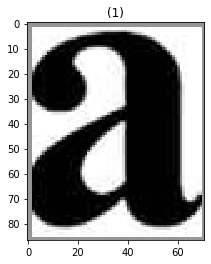

In [90]:
#readletters() #get letters with histogram in dictionary
fill_dict_images() #get letters with image in dictionary
#print(alphabetics_dict)

show_images([alphabetics_dict['A']])
#print(alphabetics_dict)

In [91]:
def Main():
    image=read_image('images1.jpg')
    gray=rgbtogray(image)
    ret,thres=convert_to_binary(gray)
    img_dilation=dilation(thres)
    sorted_cntrs=find_contours(img_dilation)
    #Extractedletters = match_letters_yousry( sorted_cntrs,image )
    Extractedletters = matchfromdifference( sorted_cntrs,image )

    print(Extractedletters)
Main()    

grayroi shape: 38 29
letter shape: 87 71
letter shape: 120 81
letter shape: 88 63
letter shape: 120 82
letter shape: 88 63
letter shape: 120 62
letter shape: 122 73
letter shape: 118 81
letter shape: 84 41
letter shape: 118 88
letter shape: 118 41
letter shape: 86 128
letter shape: 87 81
letter shape: 88 71
letter shape: 122 81
letter shape: 122 82
letter shape: 87 65
letter shape: 88 52
letter shape: 112 50
letter shape: 86 81
letter shape: 86 80
letter shape: 87 116
letter shape: 85 76
letter shape: 119 80
letter shape: 85 68
letter shape: 121 71
letter shape: 121 59
letter shape: 120 69
letter shape: 122 70
letter shape: 120 72
letter shape: 119 70
letter shape: 122 71
letter shape: 119 71
letter shape: 121 71
letter shape: 121 71
letter shape: 87 71
letter shape: 120 81
letter shape: 88 63
letter shape: 120 82
letter shape: 88 63
letter shape: 120 62
letter shape: 122 73
letter shape: 118 81
letter shape: 84 41
letter shape: 118 88
letter shape: 118 41
letter shape: 86 128
letter s

grayroi shape: 38 26
letter shape: 87 71
letter shape: 120 81
letter shape: 88 63
letter shape: 120 82
letter shape: 88 63
letter shape: 120 62
letter shape: 122 73
letter shape: 118 81
letter shape: 84 41
letter shape: 118 88
letter shape: 118 41
letter shape: 86 128
letter shape: 87 81
letter shape: 88 71
letter shape: 122 81
letter shape: 122 82
letter shape: 87 65
letter shape: 88 52
letter shape: 112 50
letter shape: 86 81
letter shape: 86 80
letter shape: 87 116
letter shape: 85 76
letter shape: 119 80
letter shape: 85 68
letter shape: 121 71
letter shape: 121 59
letter shape: 120 69
letter shape: 122 70
letter shape: 120 72
letter shape: 119 70
letter shape: 122 71
letter shape: 119 71
letter shape: 121 71
letter shape: 121 71
letter shape: 87 71
letter shape: 120 81
letter shape: 88 63
letter shape: 120 82
letter shape: 88 63
letter shape: 120 62
letter shape: 122 73
letter shape: 118 81
letter shape: 84 41
letter shape: 118 88
letter shape: 118 41
letter shape: 86 128
letter s

In [65]:
#match letters with input image by histogram
def match_letters(sorted_ctrs,inputimage):
    globalresult=[]
    for i, ctr in enumerate(sorted_ctrs):
        x, y, w, h = cv2.boundingRect(ctr)
        # Getting ROI
        roi = inputimage[y:y + h, x:x + w]
        grayroi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        localresult=[]
        for key in alphabetics_dict:
            value = alphabetics_dict[key]
            if np.array([histogram(grayroi)]).shape!=np.array([value]).shape:
                continue
            d = cv2.compareHist(np.float32(histogram(grayroi)),np.float32(value), cv2.HISTCMP_BHATTACHARYYA)
            localresult.append(d)
        mini=min(localresult)    
        for key_min in alphabetics_dict:
            value_min= alphabetics_dict[key_min]
            if np.array([histogram(grayroi)]).shape!=np.array([value_min]).shape:
                continue
            d = cv2.compareHist(np.float32(histogram(grayroi)),np.float32(value_min), cv2.HISTCMP_BHATTACHARYYA)
            if d==mini:
                globalresult.append(key_min)
    return globalresult     

In [66]:
#match letters with input image by histogram
def match_letters(sorted_ctrs,inputimage):
    globalresult=[]
    for i, ctr in enumerate(sorted_ctrs):
        x, y, w, h = cv2.boundingRect(sorted_ctrs[i])
        # Getting ROI
        roi = inputimage[y:y + h, x:x + w]
        grayroi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        localresult=10000000
        char=[]
        for input_letter in alphabetics_dict:
            input_hist = alphabetics_dict[input_letter]
            if np.array([histogram(grayroi)]).shape!=np.array([input_hist]).shape:
                continue
            d = cv2.compareHist(np.float32(histogram(grayroi)),np.float32(input_hist), cv2.HISTCMP_BHATTACHARYYA)
            if d < localresult:
                localresult = d
                char.append(input_letter)
        globalresult.append( char[-1] )  
        del char[:]
    
    return globalresult   

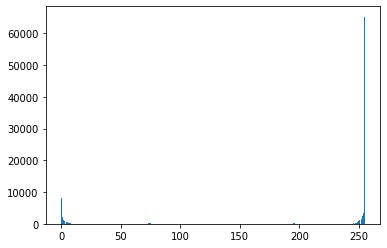

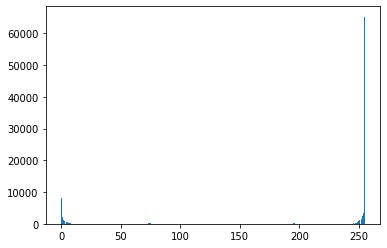

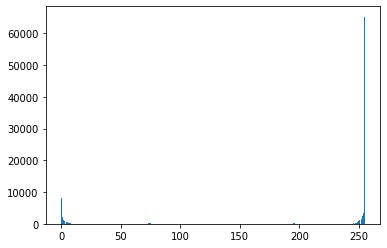

In [67]:
image=read_image('images1.jpg')
# hist=histogram(image)
showHist(image[:,:,0])
showHist(image[:,:,1])
showHist(image[:,:,2])